In [1]:
import pandas as pd
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import numpy as np 
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mtick
from scipy.stats import ttest_1samp
from datetime import datetime
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文黑体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [2]:
# 导入CRSP数据
crsp_daily = pd.read_csv('E:/Replications/JT 1993/1960-1991.csv', dtype={'PERMNO': str})
cols_keep = ['PERMNO','date', 'SHRCD', 'EXCHCD', 'DLRET', 'PRC', 'RET', 'SHROUT']
crsp_daily = crsp_daily[cols_keep]
crsp_daily.head()

,PERMNO,date,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT
0,10000,1986-01-06,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-01-07,10.0,3.0,NaN,-2.5625,C,3680.0
2,10000,1986-01-08,10.0,3.0,NaN,-2.5000,-0.024390,3680.0
3,10000,1986-01-09,10.0,3.0,NaN,-2.5000,0.000000,3680.0
4,10000,1986-01-10,10.0,3.0,NaN,-2.5000,0.000000,3680.0


In [3]:
crsp_daily["date"] = pd.to_datetime(crsp_daily["date"], errors='coerce')
# 创建年-月字段
crsp_daily["y_m"] = crsp_daily["date"].dt.to_period("M")
crsp_daily.head()

,PERMNO,date,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT,y_m
0,10000,1986-01-06,NaN,NaN,NaN,NaN,NaN,NaN,1986-01
1,10000,1986-01-07,10.0,3.0,NaN,-2.5625,C,3680.0,1986-01
2,10000,1986-01-08,10.0,3.0,NaN,-2.5000,-0.024390,3680.0,1986-01
3,10000,1986-01-09,10.0,3.0,NaN,-2.5000,0.000000,3680.0,1986-01
4,10000,1986-01-10,10.0,3.0,NaN,-2.5000,0.000000,3680.0,1986-01


In [4]:
# 筛选普通股（SHRCD=10或11）+ NYSE 或 AMEX（EXCHCD=1或2）
mask_shrcd = crsp_daily['SHRCD'].isin([10, 11])
mask_exchcd = crsp_daily['EXCHCD'].isin([1, 2])
crsp_daily = crsp_daily[mask_shrcd & mask_exchcd].copy()

In [5]:
crsp_daily.replace(["A", "S", "C", "T", "P"], np.nan, inplace = True)
crsp_daily[["SHRCD", "EXCHCD", "SHROUT"]] = crsp_daily[["SHRCD", "EXCHCD", "SHROUT"]].fillna(-99)
crsp_daily[["PERMNO", "SHRCD", "EXCHCD", "SHROUT"]] = crsp_daily[["PERMNO", "SHRCD", "EXCHCD", "SHROUT"]].astype(int)
crsp_daily.replace([-99], np.nan, inplace = True)

In [6]:
crsp_daily["RET"] = crsp_daily["RET"].astype(float)
# 过滤掉缺失收益率、无意义的回报
crsp_daily = crsp_daily[crsp_daily['RET'].notna()]
crsp_daily = crsp_daily[crsp_daily['RET'] > -1]  # RET = -1 表示退市或其他极端负值（可视情况而定）
crsp_daily = crsp_daily.sort_values(by=['PERMNO', 'date']).reset_index(drop=True)
crsp_daily

,PERMNO,date,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT,y_m
0,10006,1960-01-04,10,1,NaN,50.375,0.038660,1418.0,1960-01
1,10006,1960-01-05,10,1,NaN,51.500,0.022333,1418.0,1960-01
2,10006,1960-01-06,10,1,NaN,51.500,0.000000,1418.0,1960-01
3,10006,1960-01-07,10,1,NaN,50.750,-0.014563,1418.0,1960-01
4,10006,1960-01-08,10,1,NaN,50.375,-0.007389,1418.0,1960-01
...,...,...,...,...,...,...,...,...,...
16796438,93236,1991-12-24,11,2,NaN,15.125,-0.024194,3447.0,1991-12
16796439,93236,1991-12-26,11,2,NaN,15.125,0.000000,3447.0,1991-12
16796440,93236,1991-12-27,11,2,NaN,14.875,-0.016529,3447.0,1991-12
16796441,93236,1991-12-30,11,2,NaN,15.125,0.016807,3447.0,1991-12


In [7]:
crsp_monthly = (crsp_daily.groupby(["PERMNO", "y_m"], group_keys = False)["RET"].apply(lambda x: np.prod(1 + x) - 1).reset_index(name="monthly_ret"))
crsp_monthly

,PERMNO,y_m,monthly_ret
0,10006,1960-01,0.005155
1,10006,1960-02,0.046184
2,10006,1960-03,-0.059552
3,10006,1960-04,-0.081795
4,10006,1960-05,0.048733
...,...,...,...
805238,93236,1991-08,-0.080400
805239,93236,1991-09,-0.016393
805240,93236,1991-10,0.133331
805241,93236,1991-11,-0.397059


In [8]:
# 根据过去 J=3 个月的回报来排序
# 过去3个月的复利收益
crspJK = crsp_monthly.copy()
crspJK = crspJK.rename(columns={"monthly_ret": "RET"})
crspJK["Ranking_JK"] = crspJK.groupby("PERMNO", group_keys = False)["RET"].transform(
    lambda x: (1 + x.shift(1)).rolling(3).apply(np.prod, raw=True) - 1)
crspJK

,PERMNO,y_m,RET,Ranking_JK
0,10006,1960-01,0.005155,NaN
1,10006,1960-02,0.046184,NaN
2,10006,1960-03,-0.059552,NaN
3,10006,1960-04,-0.081795,-0.011046
4,10006,1960-05,0.048733,-0.096595
...,...,...,...,...
805238,93236,1991-08,-0.080400,0.485074
805239,93236,1991-09,-0.016393,0.203951
805240,93236,1991-10,0.133331,0.208058
805241,93236,1991-11,-0.397059,0.025126


In [9]:
# 形成十个等权重组合：分组为decile 1到10
# 每月进行分组
crspJK["decile"] = crspJK.groupby("y_m", group_keys = False)["Ranking_JK"].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)
crspJK

,PERMNO,y_m,RET,Ranking_JK,decile
0,10006,1960-01,0.005155,NaN,NaN
1,10006,1960-02,0.046184,NaN,NaN
2,10006,1960-03,-0.059552,NaN,NaN
3,10006,1960-04,-0.081795,-0.011046,7.0
4,10006,1960-05,0.048733,-0.096595,4.0
...,...,...,...,...,...
805238,93236,1991-08,-0.080400,0.485074,10.0
805239,93236,1991-09,-0.016393,0.203951,9.0
805240,93236,1991-10,0.133331,0.208058,9.0
805241,93236,1991-11,-0.397059,0.025126,6.0


In [10]:
# 记录每个月形成的组合，以及它们在未来3个月的收益
# 抽取每月建仓的股票与分组信息
formation_df = crspJK[["y_m", "PERMNO", "decile", "RET"]].copy()
formation_df = formation_df.dropna(subset=["decile"])

# 建立一个“持有记录表”：每个组合持有未来3个月
holding_frames = []
for lag in range(3):
    temp = formation_df.copy()
    temp["holding_month"] = temp["y_m"] + lag  # pd.Period
    temp["lag_index"] = lag
    holding_frames.append(temp)

holding_df = pd.concat(holding_frames)

In [11]:
# 将 crspJK 的实际收益拼到 holding 表中
ret_df = crspJK[["y_m", "PERMNO", "RET"]].rename(columns={"y_m": "holding_month"})
merged = pd.merge(holding_df, ret_df, on=["holding_month", "PERMNO"], how="left", suffixes=("", "_actual"))
# 每月每组的等权平均收益
monthly_group_ret = merged.groupby(["holding_month", "decile"], group_keys = False)["RET_actual"].mean().unstack()
monthly_group_ret

decile,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
holding_month,,,,,,,,,,
1960-04,-0.030093,-0.038133,-0.027774,-0.032326,-0.018982,-0.004954,-0.017822,-0.011214,-0.009557,-0.005988
1960-05,0.012296,0.017618,0.010009,0.014020,0.023867,0.015058,0.022875,0.030105,0.044993,0.058901
1960-06,0.005506,0.019815,0.026094,0.019377,0.019581,0.022178,0.021030,0.021241,0.037653,0.026729
1960-07,-0.017273,-0.020969,-0.016720,-0.017297,-0.016646,-0.010705,-0.008595,-0.011962,-0.026227,-0.042870
1960-08,0.042548,0.035305,0.025071,0.032258,0.036808,0.037711,0.035379,0.041197,0.048654,0.048328
...,...,...,...,...,...,...,...,...,...,...
1991-10,0.003241,0.006899,0.001854,-0.001900,0.014125,0.010389,0.016794,0.015890,0.016821,0.032891
1991-11,-0.050601,-0.060068,-0.038933,-0.038898,-0.042749,-0.036233,-0.030033,-0.029737,-0.044618,-0.040117
1991-12,-0.010086,0.039767,0.059227,0.054775,0.063253,0.076168,0.071488,0.073878,0.086755,0.070591


In [12]:
# 字符串形式
filtered = monthly_group_ret.loc["1965-01":"1989-12"]
filtered

decile,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
holding_month,,,,,,,,,,
1965-01,0.114131,0.079901,0.078473,0.068915,0.058562,0.061937,0.064081,0.057065,0.065376,0.070327
1965-02,0.033718,0.035534,0.041547,0.029869,0.031545,0.037761,0.029048,0.026510,0.040406,0.032606
1965-03,0.030235,0.021474,0.014211,0.018388,0.014220,0.017018,0.008518,0.010603,0.011206,0.007862
1965-04,0.035479,0.035501,0.039961,0.040720,0.034413,0.036165,0.043708,0.051493,0.052450,0.053644
1965-05,-0.016503,-0.006502,-0.007353,-0.006905,-0.003389,-0.003794,-0.006658,-0.007940,-0.001438,-0.001177
...,...,...,...,...,...,...,...,...,...,...
1989-08,-0.012694,0.018328,0.028452,0.025528,0.030400,0.024421,0.014247,0.014468,0.029330,0.014955
1989-09,-0.019534,-0.016288,-0.010894,0.002859,-0.006818,-0.003117,-0.001377,0.001450,0.004665,-0.003252
1989-10,-0.115162,-0.085720,-0.058490,-0.068365,-0.042867,-0.047493,-0.039674,-0.042600,-0.055443,-0.073473


In [13]:
# 提取 decile 1、10
sell = filtered[1]
buy = filtered[10]
buy_sell = buy - sell

# 汇总结果
def mean_t(series):
    series = series.dropna()
    mean = series.mean()
    std_err = series.std(ddof=1) / np.sqrt(len(series))
    t_val = mean / std_err
    return mean, t_val

sell_mu, sell_t = mean_t(sell)
buy_mu, buy_t = mean_t(buy)
bs_mu, bs_t = mean_t(buy_sell)

print("J=3, K=3 结果（等权平均）")
print(f"Sell组合（第1组）: {sell_mu:.4f}")
print(f"Buy组合（第10组）: {buy_mu:.4f}")
print(f"Buy - Sell组合差: {bs_mu:.4f}")

J=3, K=3 结果（等权平均）
Sell组合（第1组）: 0.0111
Buy组合（第10组）: 0.0134
Buy - Sell组合差: 0.0022


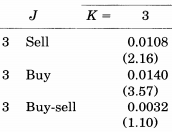

#### **Sell组合结果相差0.03%，Buy组合结果相差0.06%，Buy-Sell(高减低)组合结果相差0.10%**。

In [14]:
def run_momentum_panelA_JK(df, J, K):
    # 形成期动量（J=3/6/9/12）
    df = df.sort_values(["PERMNO", "y_m"])
    # 为每只股票计算过去 J 个月（滞后1期，即不含当月）的累积收益，用于后续排序。
    df["mom"] = df.groupby("PERMNO", group_keys = False)["RET"].transform(lambda x: (1 + x.shift(1)).rolling(J).apply(np.prod, raw=True) - 1)
    df["decile"] = df.groupby("y_m")["mom"].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates="drop") + 1)
    formation_df = df[["y_m", "PERMNO", "decile", "RET"]].dropna()

    holding_frames = []
    for lag in range(K):
        temp = formation_df.copy()
        # 每份向前平移 lag 个月，构造滚动的持有期组合
        temp["holding_month"] = temp["y_m"] + lag
        holding_frames.append(temp)
    # 最终 holding_df 表示每个月要持有哪些股票（每个 J-K 策略都持有 K 个月）
    holding_df = pd.concat(holding_frames)

    # 拼接未来收益
    ret_df = df[["y_m", "PERMNO", "RET"]].rename(columns={"y_m": "holding_month"})
    merged = pd.merge(holding_df, ret_df, on=["holding_month", "PERMNO"], how="left", suffixes=("", "_actual"))
    # 计算 decile 1、10 和 Buy-Sell 平均收益
    monthly_group_ret = merged.groupby(["holding_month", "decile"])["RET_actual"].mean().unstack()
    filtered = monthly_group_ret.loc["1965-01":"1989-12"]
    sell = filtered[1]
    buy = filtered[10]
    buy_sell = buy - sell

    # 汇总收益和 t 值    
    def mean_t(series):
        series = series.dropna()
        mean = series.mean()
        std_err = series.std(ddof=1) / np.sqrt(len(series))
        t_val = mean / std_err
        return mean, t_val

    sell_mu, sell_t = mean_t(sell)
    buy_mu, buy_t = mean_t(buy)
    bs_mu, bs_t = mean_t(buy_sell)

    return {"K": K, "Sell": (sell_mu, sell_t), "Buy": (buy_mu, buy_t), "Buy-Sell": (bs_mu, bs_t)}

In [15]:
# 运行 Panel A 的 J=3/6/9/12
results_panelA_J3 = []
results_panelA_J6 = []
results_panelA_J9 = []
results_panelA_J12 = []

for K in [3, 6, 9, 12]:
    results_panelA_J3.append(run_momentum_panelA_JK(crspJK, J=3, K=K))
    results_panelA_J6.append(run_momentum_panelA_JK(crspJK, J=6, K=K))
    results_panelA_J9.append(run_momentum_panelA_JK(crspJK, J=9, K=K))
    results_panelA_J12.append(run_momentum_panelA_JK(crspJK, J=12, K=K))

In [16]:
# 制表
def format_panelA_row(results_J):
    return pd.DataFrame({
        "K=3": [f"{results_J[0]['Sell'][0]:.4f} ({results_J[0]['Sell'][1]:.2f})",
                f"{results_J[0]['Buy'][0]:.4f} ({results_J[0]['Buy'][1]:.2f})",
                f"{results_J[0]['Buy-Sell'][0]:.4f} ({results_J[0]['Buy-Sell'][1]:.2f})"],
        "K=6": [f"{results_J[1]['Sell'][0]:.4f} ({results_J[1]['Sell'][1]:.2f})",
                f"{results_J[1]['Buy'][0]:.4f} ({results_J[1]['Buy'][1]:.2f})",
                f"{results_J[1]['Buy-Sell'][0]:.4f} ({results_J[1]['Buy-Sell'][1]:.2f})"],
        "K=9": [f"{results_J[2]['Sell'][0]:.4f} ({results_J[2]['Sell'][1]:.2f})",
                f"{results_J[2]['Buy'][0]:.4f} ({results_J[2]['Buy'][1]:.2f})",
                f"{results_J[2]['Buy-Sell'][0]:.4f} ({results_J[2]['Buy-Sell'][1]:.2f})"],
        "K=12": [f"{results_J[3]['Sell'][0]:.4f} ({results_J[3]['Sell'][1]:.2f})",
                 f"{results_J[3]['Buy'][0]:.4f} ({results_J[3]['Buy'][1]:.2f})",
                 f"{results_J[3]['Buy-Sell'][0]:.4f} ({results_J[3]['Buy-Sell'][1]:.2f})"]
    }, index=["Sell", "Buy", "Buy-Sell"])

In [17]:
# 调用函数制表
panelA_J3 = format_panelA_row(results_panelA_J3)
panelA_J6 = format_panelA_row(results_panelA_J6)
panelA_J9 = format_panelA_row(results_panelA_J9)
panelA_J12 = format_panelA_row(results_panelA_J12)

In [18]:
# 给每个表加上索引表示 J 值
panelA_J3.index = pd.MultiIndex.from_product([[3], panelA_J3.index], names=["J", "Strategy"])
panelA_J6.index = pd.MultiIndex.from_product([[6], panelA_J6.index], names=["J", "Strategy"])
panelA_J9.index = pd.MultiIndex.from_product([[9], panelA_J9.index], names=["J", "Strategy"])
panelA_J12.index = pd.MultiIndex.from_product([[12], panelA_J12.index], names=["J", "Strategy"])

# 合并四个部分
panelA_full = pd.concat([panelA_J3, panelA_J6, panelA_J9, panelA_J12])
panelA_full

K=3            K=6            K=9           K=12
J  Strategy                                                            
3  Sell      0.0111 (2.23)  0.0092 (1.90)  0.0092 (1.94)  0.0087 (1.87)
   Buy       0.0134 (3.44)  0.0144 (3.65)  0.0148 (3.73)  0.0153 (3.81)
   Buy-Sell  0.0022 (0.79)  0.0052 (2.13)  0.0056 (2.58)  0.0066 (3.51)
6  Sell      0.0094 (1.81)  0.0082 (1.63)  0.0074 (1.53)  0.0082 (1.69)
   Buy       0.0162 (4.11)  0.0168 (4.21)  0.0171 (4.23)  0.0163 (4.06)
   Buy-Sell  0.0069 (2.03)  0.0086 (2.85)  0.0096 (3.64)  0.0082 (3.29)
9  Sell      0.0085 (1.61)  0.0068 (1.35)  0.0073 (1.48)  0.0083 (1.68)
   Buy       0.0179 (4.44)  0.0182 (4.45)  0.0173 (4.24)  0.0162 (4.00)
   Buy-Sell  0.0094 (2.63)  0.0114 (3.64)  0.0100 (3.38)  0.0079 (2.84)
12 Sell      0.0067 (1.29)  0.0069 (1.36)  0.0077 (1.52)  0.0089 (1.76)
   Buy       0.0187 (4.57)  0.0177 (4.33)  0.0168 (4.11)  0.0156 (3.84)
   Buy-Sell  0.0121 (3.51)  0.0108 (3.30)  0.0091 (2.92)  0.0067 (2.26)

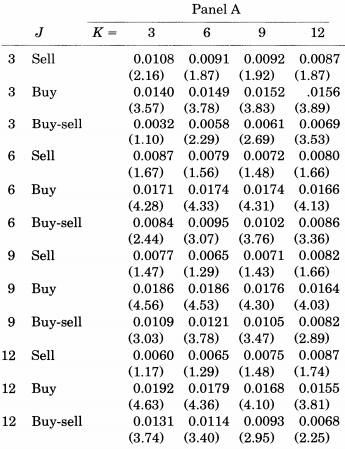

#### **用日度收益数据回报复利的确可以精确地合成每月回报，进一步提高动量策略复制的准确性**
- 相比于直接使用月度数据，大部分结果与原文的差距都变得更小甚至一致。
- 与原文的差异均在0.01% ~ 0.09%之间